# Qwen 2.5 VL + SAM: IA Conversacional para Segmentación Inteligente

Este notebook demuestra un enfoque **más avanzado y conversacional** para segmentación usando **Qwen2.5-VL**, un modelo multimodal que entiende tanto imágenes como texto natural.

## Configuración e Imports

Importamos **Transformers** y **qwen-vl-utils**, que nos permite usar modelos de visión y lenguaje para conversaciones sobre imágenes de forma sencilla, gratuita y en local.

In [1]:
try:
    import qwen_vl_utils
except ImportError:
    !pip install qwen-vl-utils
    import qwen_vl_utils
import torch
import transformers
from huggingface_hub import snapshot_download
from transformers import SamProcessor, SamModel
from transformers import AutoProcessor
from transformers import Qwen2_5_VLForConditionalGeneration
from qwen_vl_utils import process_vision_info
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import requests
import json
import re
from pathlib import Path
import sys
from io import BytesIO
import warnings
warnings.filterwarnings("ignore")
transformers.logging.set_verbosity_error()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch version: {torch.__version__}, using device: {device}")
print(f"transformers version: {transformers.__version__}")

torch version: 2.6.0+cu124, using device: cuda
transformers version: 4.52.4


## Descarga de Modelos en Local

**Diferencia clave**: Solo necesitamos dos modelos para este enfoque más simplificado:

- **Qwen2.5-VL-3B**: Modelo multimodal que entiende imágenes y texto como una conversación
- **SAM**: Segmentación precisa (igual que en el notebook anterior)

**Ventaja**: Qwen reemplaza múltiples modelos (DINO, CLIP, BLIP) con uno solo más potente.


In [2]:
if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    HF_MODELS_DIR = Path("/content/drive/MyDrive/hf_models")
else:
    HF_MODELS_DIR = Path(r"G:\Mi unidad\hf_models")

HF_MODELS_DIR.mkdir(parents=True, exist_ok=True)

models = [
    "facebook/sam-vit-large",
    "Qwen/Qwen2.5-VL-3B-Instruct"
]

for repo in models: #Atención! descargará unos 7 GB mas a Google Drive
    local_dir = HF_MODELS_DIR / repo
    snapshot_download(
        repo_id=repo,
        local_dir=str(local_dir),
        local_dir_use_symlinks=False,
        resume_download=True
)

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

## Carga de Modelos

**Qwen2.5-VL** es un modelo **multimodal** que puede:
- Responder preguntas sobre imágenes
- Detectar objetos cuando se lo pedimos  
- Generar bounding boxes en formato JSON
- Mantener conversaciones sobre el contenido visual


In [ ]:
# models

# utilizar estos para no descargarlos en local
sam_path = "facebook/sam-vit-large"
qwen_path = "Qwen/Qwen2.5-VL-3B-Instruct"

# utilizar estos si están descargados en local
# sam_path = HF_MODELS_DIR / "facebook/sam-vit-large"
# qwen_path = HF_MODELS_DIR / "Qwen/Qwen2.5-VL-3B-Instruct"

sam_processor = SamProcessor.from_pretrained(sam_path)
sam_model = SamModel.from_pretrained(sam_path).to(device)

qwen_processor = AutoProcessor.from_pretrained(qwen_path)
qwen_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(qwen_path, torch_dtype=torch.float16, device_map="auto") # usamos half rpecision fp16 para que sea más rápido y ligero


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Carga de Imágenes de Ejemplo

Usamos las mismas imágenes que en el notebook anterior para poder comparar ambos enfoques.


In [4]:
# images
url_cars = "https://github.com/sergiovillanueva/prompt_to_mask/raw/master/assets/cars.jpg"
image_cars = Image.open(BytesIO(requests.get(url_cars).content)).convert("RGB")

url_person_cars = "https://github.com/sergiovillanueva/prompt_to_mask/raw/master/assets/person_cars.jpg"
image_person_cars = Image.open(BytesIO(requests.get(url_person_cars).content)).convert("RGB")

url_fruits = "https://github.com/sergiovillanueva/prompt_to_mask/raw/master/assets/fruits.jpg"
image_fruits = Image.open(BytesIO(requests.get(url_fruits).content)).convert("RGB")

url_park = "https://github.com/sergiovillanueva/prompt_to_mask/raw/master/assets/park.jpg"
image_park = Image.open(BytesIO(requests.get(url_park).content)).convert("RGB")

url_carpet_ok = "https://github.com/sergiovillanueva/prompt_to_mask/raw/master/assets/carpet_ok.jpg"
image_carpet_ok = Image.open(BytesIO(requests.get(url_carpet_ok).content)).convert("RGB")

url_carpet_nok = "https://github.com/sergiovillanueva/prompt_to_mask/raw/master/assets/carpet_nok.jpg"
image_carpet_nok = Image.open(BytesIO(requests.get(url_carpet_nok).content)).convert("RGB")

url_board = "https://github.com/sergiovillanueva/prompt_to_mask/raw/master/assets/board.jpg"
image_board = Image.open(BytesIO(requests.get(url_board).content)).convert("RGB")

url_cut = "https://github.com/sergiovillanueva/prompt_to_mask/raw/master/assets/cut.jpg"
image_cut = Image.open(BytesIO(requests.get(url_cut).content)).convert("RGB")

## **Qwen 2.5 VL**: Conversación sobre Imágenes

Qwen2.5-VL es un modelo multimodal conversacional que combina visión y lenguaje.

Puede analizar imágenes y responder preguntas en lenguaje natural o formato estructurado.

- Modelo multimodal: procesa texto + imágenes simultáneamente
- Arquitectura Transformer con Vision Encoder integrado
- 3B parámetros: balance entre rendimiento y eficiencia
- Entrenamiento conversacional: entiende instrucciones complejas
- Salida estructurada: puede generar JSON
- Zero-shot: funciona sin entrenamiento adicional


**Proceso**:
1. Creamos un mensaje tipo chat con imagen y pregunta
2. `apply_chat_template` formatea la conversación
3. `process_vision_info` extrae la información visual
4. El modelo genera respuestas en lenguaje natural
5. El modelo puede devolver respuestas estructuradas en JSON o texto libre según se solicite


**Ventaja**: Mucho más flexible que modelos especializados - podemos hacer **cualquier pregunta**.

**Desventaja**: Más pesado y lento que las otras alternativas.

Model Card: https://huggingface.co/Qwen/Qwen2.5-VL-3B-Instruct

Paper: https://arxiv.org/pdf/2502.13923



Prompt: How many cars are in the image? . 
Answer: There are five cars visible in the image.



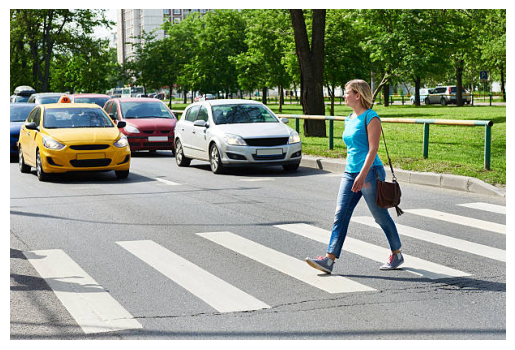

In [18]:
# qwen
def answer_question(image, prompt):
    """Answer questions about images using Qwen model."""
    
    # Crear estructura de conversación con imagen y texto
    messages = [{"role": "user", "content": [{"type": "image", "image": image}, {"type": "text", "text": prompt}]}]

    # Convertir mensajes al formato que espera el modelo
    text = qwen_processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    
    # Extraer y procesar información visual de los mensajes
    image_inputs, video_inputs = process_vision_info(messages)
    
    # Tokenizar texto, procesar imágenes y crear tensores finales
    inputs = qwen_processor(text=[text], images=image_inputs, videos=video_inputs, padding=True, return_tensors="pt").to(device)

    with torch.no_grad():
        generated_ids = qwen_model.generate(**inputs, max_new_tokens=256) #tamaño maximo de la respuesta
        
    # Decodificar solo la parte nueva generada
    answer = qwen_processor.batch_decode([out[len(inp):] for inp, out in zip(inputs.input_ids, generated_ids)], skip_special_tokens=True)[0]
    print(f"\nPrompt: {prompt} \nAnswer: {answer}\n")

    img_array = np.array(image)
    
    # Buscar JSON en la respuesta
    json_match = re.search(r'```json\n(.*?)\n```', answer, re.DOTALL)
    if json_match:
        data = json.loads(json_match.group(1))
        
        if data:
            for item in data:
                if 'bbox_2d' in item:
                    x1, y1, x2, y2 = item['bbox_2d']
                    label = item.get('label', 'object')
                    
                    cv2.rectangle(img_array, (x1, y1), (x2, y2), (0, 0, 255), 3)
                    cv2.putText(img_array, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            
    plt.imshow(img_array)
    plt.axis("off")
    plt.show()
    return

answer_question(image_person_cars, "How many cars are in the image? .")


## Pipeline Avanzado: Qwen + SAM

**Proceso**:
1. **Qwen** entiende instrucciones complejas en lenguaje natural
2. Genera bounding boxes en **formato JSON estructurado**
3. **SAM** convierte las cajas en máscaras precisas

**Ventajas sobre Grounding DINO**:
- **Instrucciones más complejas**: "Detecta coches pero no los amarillos"
- **Respuestas estructuradas**: JSON automático con etiquetas y coordenadas
- **Mayor flexibilidad**: Un solo modelo para múltiples tareas



Prompt: Detect the fruits that are from Valenci and provide bounding box coordinates. 
Answer: ```json
[
	{"bbox_2d": [35, 298, 251, 517], "label": "fruits that are from Valenci"}
]
```



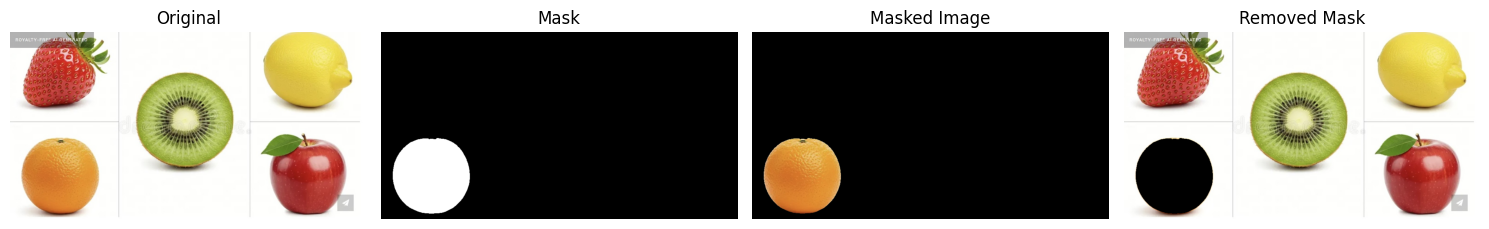

In [21]:
# qwen + sam

def segment_objects(image, prompt):
    """Segment objects using Qwen + SAM pipeline"""
    
    boxes = []
    labels = []
    
    if image is None:
        messages = [{"role": "user", "content": [{"type": "text", "text": prompt}]}]
    else:
        messages = [{"role": "user", "content": [{"type": "image", "image": image}, {"type": "text", "text": prompt}]}]

    text = qwen_processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = qwen_processor(text=[text], images=image_inputs, videos=video_inputs, padding=True, return_tensors="pt").to(device)

    with torch.no_grad():
        generated_ids = qwen_model.generate(**inputs, max_new_tokens=256)
        
    answer = qwen_processor.batch_decode([out[len(inp):] for inp, out in zip(inputs.input_ids, generated_ids)], skip_special_tokens=True)[0]
    print(f"\nPrompt: {prompt} \nAnswer: {answer}\n")

    if image is None:
        return answer

    json_match = re.search(r'```json\n(.*?)\n```', answer, re.DOTALL)
    if json_match:
        data = json.loads(json_match.group(1))
        if data:
            img_array = np.array(image)
            for item in data:
                if 'bbox_2d' in item:
                    x1, y1, x2, y2 = item['bbox_2d']
                    label = item.get('label', 'object')
                    boxes.append([x1, y1, x2, y2])
                    labels.append(label)

    w, h = image.size
    final_mask = np.zeros((h, w), dtype=np.float32)

    if len(boxes) > 0:
        sam_inputs = sam_processor(images=image, input_boxes=[boxes], return_tensors="pt").to(device)

        with torch.no_grad():
            sam_outputs = sam_model(**sam_inputs)

        masks = sam_processor.post_process_masks(sam_outputs.pred_masks, sam_inputs["original_sizes"], sam_inputs["reshaped_input_sizes"])
        iou_scores = sam_outputs.iou_scores.cpu().numpy()
        final_mask = np.zeros((h, w), dtype=np.float32)

        for i in range(len(boxes)):
            detection_masks = masks[0][i].cpu().numpy()
            best_idx = iou_scores[0][i].argmax()
            final_mask += detection_masks[best_idx]

        
    final_mask = np.clip(final_mask, 0, 1)
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))) #Usamos filtro morfológico close para eliminar ruido
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    axes[0].imshow(image)
    axes[0].set_title("Original")
    axes[0].axis("off")
    axes[1].imshow(final_mask, cmap="gray")
    axes[1].set_title("Mask")
    axes[1].axis("off")
    masked_img = np.array(image) * final_mask[:,:,None]
    axes[2].imshow(masked_img.astype(np.uint8))
    axes[2].set_title("Masked Image")
    axes[2].axis("off")
    inverted_mask = 1 - final_mask
    removed_img = np.array(image) * inverted_mask[:,:,None]
    axes[3].imshow(removed_img.astype(np.uint8))
    axes[3].set_title("Removed Mask")
    axes[3].axis("off")
    plt.tight_layout()
    plt.show()
    
    return final_mask

mask = segment_objects(image_fruits, "Detect the fruits that are from Valenci and provide bounding box coordinates.")


## Ejercicio: Calcular perímetro

Vamos a calcular el perímetro del lago de Central Park usando la imagen `image_park`.  

La solución consiste en:
1. Segmentar la superficie de Central Park para obtener la escala
2. Segmentar el lago dentro del parque
3. Calcular el perímetro usando la escala obtenida


![Central Park](assets/park.jpg)




Sustituye los `None` por los valores correctos.




Prompt: Detect the surface of central park and provide bounding box coordinates. 
Answer: ```json
[
	{"bbox_2d": [185, 34, 376, 960], "label": "surface of central park"}
]
```



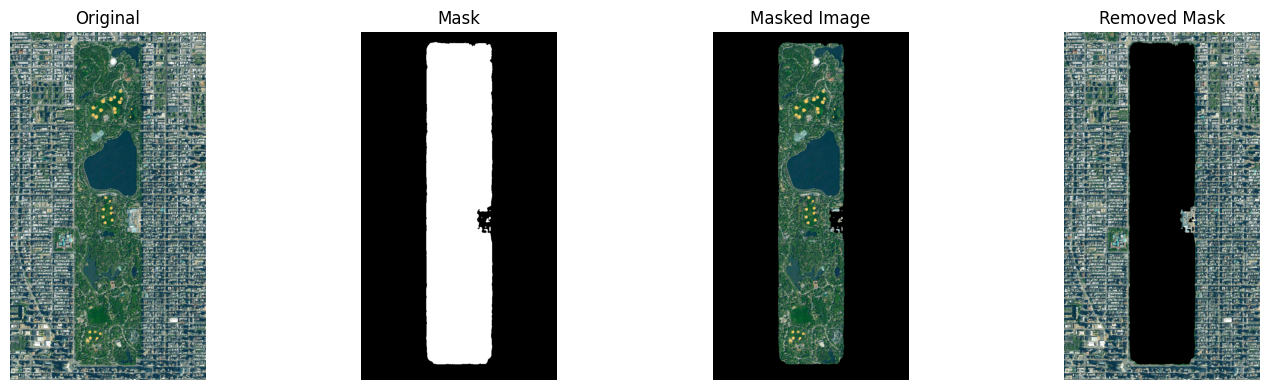


Prompt: Detect the the lake of central park and provide bounding box coordinates. 
Answer: ```json
[
	{"bbox_2d": [186, 283, 370, 475], "label": "the lake of central park"}
]
```



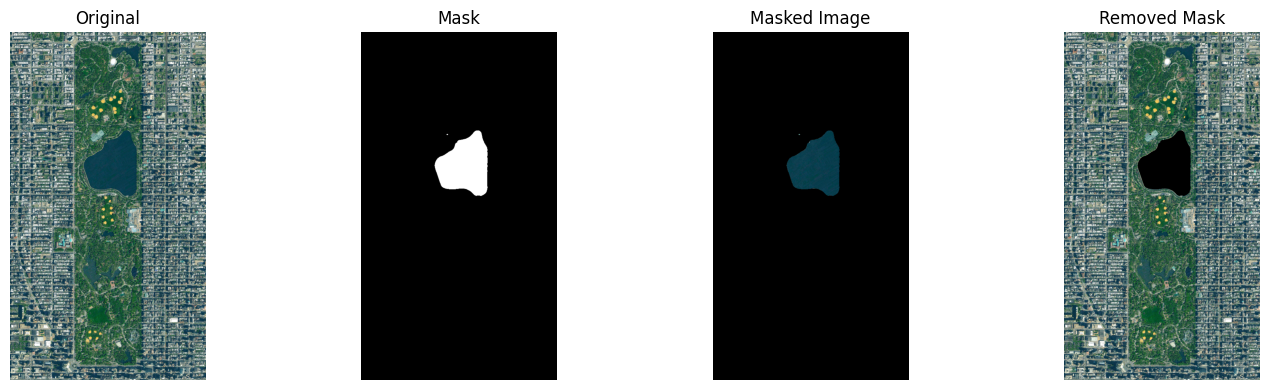


Prompt: Width of central park? 
Answer: The width of Central Park in New York City is approximately 2.5 miles (4 kilometers).



In [22]:
park_mask = segment_objects(image_park, "Detect the surface of central park and provide bounding box coordinates.") # <- Segmentar la superficie de Central Park
lake_mask = segment_objects(image_park, "Detect the the lake of central park and provide bounding box coordinates.") # <- Segmentar la superficie del lago

park_height = segment_objects(None, "Width of central park?")

In [25]:

real_height_km = 4  # <- Altura real de central park

park_coords = np.column_stack(np.where(park_mask > 0)) #Convertimos a coordenadas x,y
y_min = park_coords[:, 0].min()
y_max = park_coords[:, 0].max()

#calculamos el peso pixel
park_height_px = y_max - y_min # <- Altura de la superficie de Central Park en pixeles

print(park_height_px)

km_per_pixel = real_height_km / park_height_px # <- Peso de un pixel en km

print(km_per_pixel)

# Calculamos el contorno del blob del lago
contours, _ = cv2.findContours(lake_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
perimeter_px = cv2.arcLength(max(contours, key=cv2.contourArea), True)

# calculamos el perimetro en km
perimeter_km = perimeter_px * km_per_pixel # <- Perimetro del lago en km

print(f"Lake perimeter: {perimeter_km:.2f} km")

925
0.004324324324324324
Lake perimeter: 2.55 km
